In [87]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
train_data=pd.read_csv('./titanic/train.csv')
test_data=pd.read_csv('./titanic/test.csv')

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
test_data.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
test_ids=test_data['PassengerId']

### Let's analyze the training data

In [9]:
train_data.shape

(891, 12)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### According to me columns such as Name, Ticket, Fare, and Cabin would not matter into detecting/analyzing whether the passenger would survive or not

In [11]:
train_data.drop(columns=['Name', 'Ticket', 'Cabin', 'Fare'], inplace=True)

In [12]:
test_data.drop(columns=['Name', 'Ticket', 'Cabin', 'Fare'], inplace=True)

In [13]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Embarked         2
dtype: int64

### Let's impute the Age column with the mean values

In [14]:
train_data['Age']=train_data['Age'].fillna(train_data['Age'].mean())

### Let's impute the Embarked column with the mode value

In [15]:
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])

In [16]:
train_data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Embarked       0
dtype: int64

### Now we do not have any missing values. Let's do some Exploratory Data Analysis (EDA)

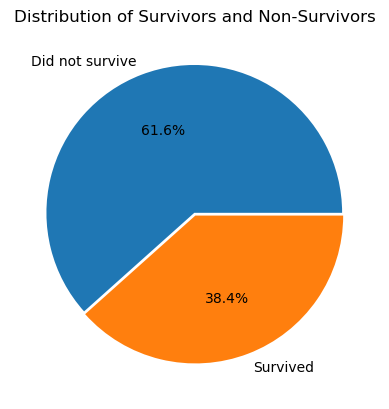

In [17]:
labels=['Did not survive', 'Survived']
plt.pie(train_data['Survived'].value_counts(), labels=labels, autopct='%1.1f%%', explode=[0.01, 0.01])
plt.title("Distribution of Survivors and Non-Survivors")
plt.show()

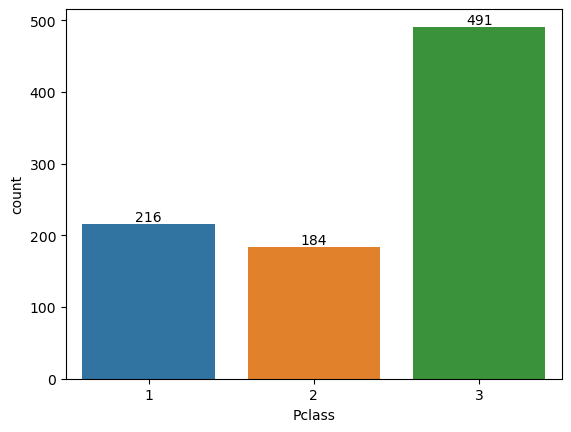

In [18]:
ax=sns.countplot(x='Pclass', data=train_data)
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

### The above graph shows that the majority of the people got the lower class tickets (class: 3), and then upper (class 1), and then middle (class 2)

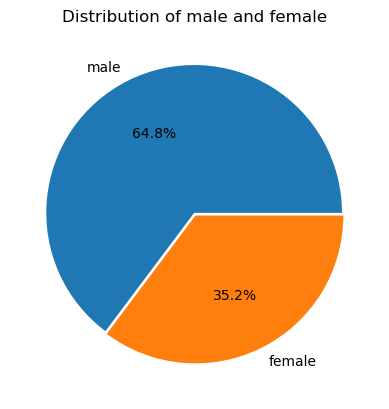

In [19]:
plt.pie(train_data['Sex'].value_counts(), labels=train_data['Sex'].value_counts().index, autopct='%1.1f%%', explode=[0.01, 0.01])
plt.title("Distribution of male and female")
plt.show()

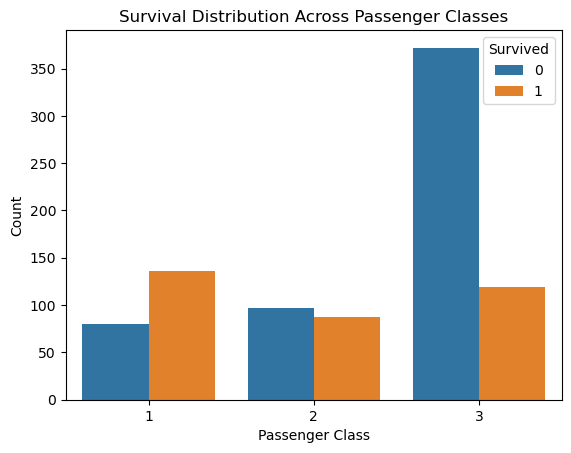

In [20]:
sns.countplot(x='Pclass', hue='Survived', data=train_data)
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.title("Survival Distribution Across Passenger Classes")
plt.show()

### We can see from the above graph that majority of people who were in Pclass 3, survived and the least survived in Pclass 1.

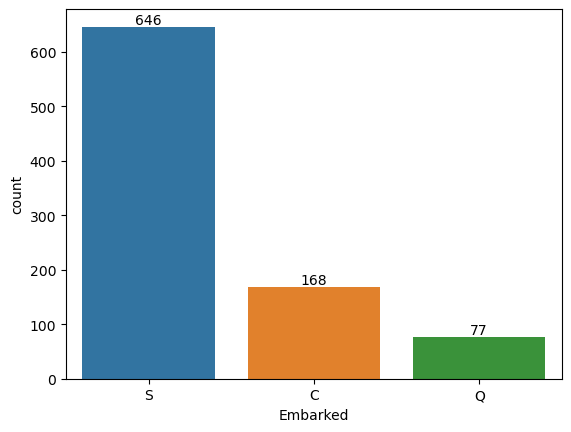

In [21]:
ax=sns.countplot(x='Embarked', data=train_data)
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

### Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

### Let's convert the object columns using Label Encoder

In [22]:
categorical_features = train_data.select_dtypes(include=["object"]).columns
print(categorical_features)

Index(['Sex', 'Embarked'], dtype='object')


In [23]:
X=train_data.drop(columns=['Survived'])
y=train_data['Survived']

In [24]:
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    
    # Combine train and test data before fitting to avoid unseen labels issue
    le.fit(pd.concat([X[col], test_data[col]], axis=0))
    
    X[col] = le.transform(X[col])
    test_data[col] = le.transform(test_data[col])
    
    # Store the encoder
    label_encoders[col] = le

In [25]:
enocer=LabelEncoder()

In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Embarked     891 non-null    object 
dtypes: float64(1), int64(5), object(2)
memory usage: 55.8+ KB


In [27]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (712, 7)
X_test shape: (179, 7)
y_train shape: (712,)
y_test shape: (179,)


### Now, let's scale the data

In [29]:
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Let's start the modelling

### Logistic Regression

In [30]:
log_model=LogisticRegression()

In [31]:
log_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [32]:
y_pred=log_model.predict(X_test_scaled)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



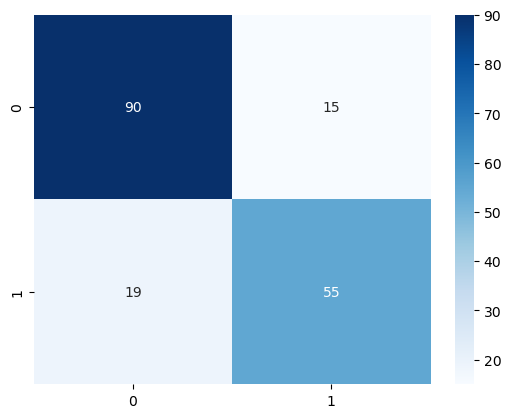

In [34]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')
plt.show()

In [35]:
log_model_scores=log_model.predict_proba(X_test_scaled)[:, 1]

In [36]:
fpr, tpr, thresholds=roc_curve(y_test, log_model_scores)

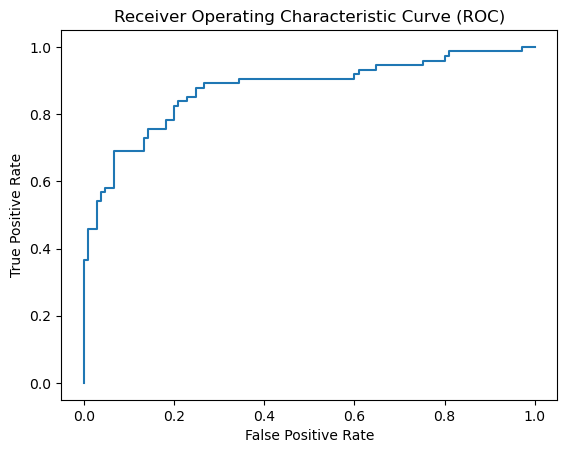

In [37]:
plt.plot(fpr, tpr)
plt.title("Receiver Operating Characteristic Curve (ROC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [38]:
optimal_idx=np.argmax(tpr-fpr)
optimal_threshold=thresholds[optimal_idx]
print("Optimal threshold value for Logistic Regression:", optimal_threshold)

Optimal threshold value for Logistic Regression: 0.3147263194390443


In [39]:
log_model_pred_adjusted=(log_model_scores>=optimal_threshold).astype(int)

In [40]:
print(classification_report(y_test, log_model_pred_adjusted))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       105
           1       0.71      0.88      0.79        74

    accuracy                           0.80       179
   macro avg       0.81      0.82      0.80       179
weighted avg       0.82      0.80      0.81       179



In [41]:
test_data.isna().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Embarked        0
dtype: int64

In [42]:
test_data['Age']=test_data['Age'].fillna(test_data['Age'].mean())

In [43]:
test_data_scaled=scaler.transform(test_data)

In [44]:
predictions1=log_model.predict(test_data_scaled)

In [45]:
submission1 = pd.DataFrame({"PassengerId": test_ids, "Survived": predictions1})
submission1.to_csv("submission1.csv", index=False)
print("Submission1 file created!")

Submission1 file created!


In [46]:
log_model_scores1=log_model.predict_proba(test_data_scaled)[:,1]

In [47]:
predictions2=(log_model_scores1>=optimal_threshold).astype(int)

In [48]:
submission2 = pd.DataFrame({"PassengerId": test_ids, "Survived": predictions2})
submission2.to_csv("submission2.csv", index=False)
print("Submission2 file created!")

Submission2 file created!


### Performance decreased after submission2

### Alright! Best score rank is 13,607 after this submission 1. Lol! Let's improve this

In [49]:
dt_classifier=DecisionTreeClassifier()

In [50]:
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [51]:
y_pred1=dt_classifier.predict(X_test)

In [52]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       105
           1       0.73      0.66      0.70        74

    accuracy                           0.76       179
   macro avg       0.75      0.75      0.75       179
weighted avg       0.76      0.76      0.76       179



In [53]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print(grid_search.best_params_)

# Train the best model
best_dt = grid_search.best_estimator_

{'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [55]:
y_pred_dt = best_dt.predict(X_test)

In [56]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.65      0.73        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.78       179
weighted avg       0.80      0.80      0.79       179



### We can see that the score increased (precision and f1-score), but it's just the recall (sensitivity) that decreased. Let's balance our dataset and then check if the recall score increases or not

### I'm going to use SMOTE analysis

In [58]:
smote=SMOTE()

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(y_train_smote.value_counts())

0    444
1    444
Name: Survived, dtype: int64


### Now that we have balanced the dataset, let's analyze the model performance

In [62]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Best parameters
print(grid_search.best_params_)

# Train the best model
best_dt = grid_search.best_estimator_

{'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10}


In [63]:
best_dt.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, min_samples_split=10)

In [64]:
y_pred_dt1=best_dt.predict(X_test)

In [65]:
print(classification_report(y_test, y_pred_dt1))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.65      0.73        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.78       179
weighted avg       0.80      0.80      0.79       179



In [67]:
predictions3=best_dt.predict(test_data)

In [68]:
submission3=pd.DataFrame({"PassengerId": test_ids, "Survived": predictions3})
submission3.to_csv("submission3.csv", index=False)
print("Submission3 file created!")

Submission3 file created!


### Great news!!! The rank is 4,617 now! Earlier it was 13,607. That's a fantastic jump!

### The score decreased. So let's optimize the performance of random forest with hyperparameter tuning

In [78]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=best_dt.get_params()['max_depth'], random_state=42, n_jobs=-1)
rf_model.fit(X_train_smote, y_train_smote)

y_pred_rf = rf_model.predict(X_test)

In [79]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       105
           1       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



In [81]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_search = RandomizedSearchCV(
    rf_model, param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)

rf_search.fit(X_train_smote, y_train_smote)

best_rf = rf_search.best_estimator_
print("Best Parameters:", rf_search.best_params_)

Best Parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30}


In [82]:
y_pred_rf=best_rf.predict(X_test)

In [83]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [84]:
predictions4=best_rf.predict(test_data)

In [93]:
submission4=pd.DataFrame({"PassengerId": test_ids, "Survived": predictions4})
submission4.to_csv("submission4.csv", index=False)
print("Submission4 file created!")

Submission4 file created!


In [88]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb_model, param_grid, n_iter=20, scoring='accuracy', cv=5, n_jobs=-1, random_state=42
)
xgb_search.fit(X_train_smote, y_train_smote)

best_xgb = xgb_search.best_estimator_

In [89]:
y_pred_xgb=best_xgb.predict(X_test)

In [90]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



In [94]:
predictions5=best_rf.predict(test_data)

In [95]:
submission5=pd.DataFrame({"PassengerId": test_ids, "Survived": predictions5})
submission5.to_csv("submission5.csv", index=False)
print("Submission5 file created!")

Submission5 file created!


### So far, the model which has performed the best is optimized Decision Tree Classifier (submission3).

# Thank you!!